# M1. Actividad 
<hr>

### Jorge de Jesús Castro Vázquez | A01707735

Modelación de sistemas multiagentes con gráficas computacionales

# **Intrucciones:**

Para este problema, deberás entregar, de manera individual, un informe en PDF que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo solicita en el siguiente documento.

**Dado:**

* Habitación de MxN espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución.

**Realiza la siguiente simulación:**

* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].
* En cada paso de tiempo:
  * Si la celda está sucia, entonces aspira.
  * Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
* Se ejecuta el tiempo máximo establecido.

**Deberás recopilar la siguiente información durante la ejecución:**

* Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
* Porcentaje de celdas limpias después del termino de la simulación.
* Número de movimientos realizados por todos los agentes.

In [110]:
#La clase Model para manejar los agentes y la clase Agent para un definir un agente.
from mesa import Agent, Model

# Debido a que necesitamos varios agentes por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Con ''DataCollector'', vamos a recuperar información del modelo.
from mesa.datacollection import DataCollector

# matplotlib lo vamos a utilizar para realizar una ''animación'' de mi modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquete que vamos a usar para medir el tiempo de ejecución del modelo
import time
import datetime
from timeit import default_timer as timer

MAXVAL = 10000

# Declaración de la Clase Agente

Se crea la clase del agente: _RobotVacuumClearAgent_

In [3]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                                  [ 0, -1],           [ 0, +1],
                                  [+1, -1], [+1,  0], [+1, +1] ])
        self.steps = 0
        
    def can_move(self, x, y):
        return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)
    
    
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
        else:
            i = int( np.random.rand() * MAXVAL ) % len(self.options)
            x = self.pos[0] + self.options[i][0]
            y = self.pos[1] + self.options[i][1]
            #Se toma como movimiento si se puede desplazar a alguna celda vecina
            if self.can_move(x, y):
                self.model.grid.move_agent(self, (x, y))
                self.model.step_counter += 1
                self.steps += 1
                


In [4]:
def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes agentes.
        *param* model : Modelo del que obtendrá la información. 
        *return* una matriz con la información del estado de cada uno de los agentes."""
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for x in range (model.grid.width):
        for y in range (model.grid.height):
            if model.grid.is_cell_empty( (x, y) ) :
                grid[x][y] = model.floor[x][y] * 2
            else:
                grid[x][y] = 1
    
    return grid

In [5]:
    
class RobotVacuumCleanerModel(Model):
    def __init__(self, width, height, num_agents, dirty_cells_percentage = 0.5):
        self.num_agents = num_agents
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros( (width, height) )
        self.width = width
        self.height = height
        self.step_counter = 0
        self.timer = 0
        
        # Create agents
        for i in range(self.num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a, (0, 0))
            self.schedule.add(a)
            
        # Initializate the ''dirty'' cells
        amount = int((width * height) * dirty_cells_percentage)
        for i in range(amount):
            finished = False
            while not finished:
                x = int(np.random.rand() * MAXVAL) % width
                y = int(np.random.rand() * MAXVAL) % height
                if self.floor[x][y] == 0:
                    self.floor[x][y] = 1
                    finished = True
                    
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
    def is_all_clean(self):
        return np.all(self.floor == 0)
    
    def calculate_clean_cells(self):
        total_cells = self.width * self.height
        clean_cells = int((total_cells) - np.count_nonzero(self.floor == 1))
        clean_percentage = (clean_cells * 100) / total_cells
    
        return int(clean_percentage)
        
    
    def total_steps(self):
        return self.step_counter
        
    def total_time(self):
        return self.timer
            
    def step(self):
        """ Ejecuta un paso de la simulación."""
        start = timer()
        self.datacollector.collect(self)
        self.schedule.step()
        end = timer()
        delta_time = end - start
        self.timer += delta_time

In [92]:
# Definimos el tamaño del Grid
WIDTH = 20
HEIGHT = 20

# Definimos el número de celdas iniciales a estar sucias
DIRTY_CELLS_PERCENTAGE = 0.5

# Definimos el número máximo de generaciones a correr
MAX_GENERATIONS = 200
#MAX_GENERATIONS_2 = 100 
#MAX_GENERATIONS_3 = 300

# Definimos el número de agentes que limpiaran
NUM_AGENTS = 50

NUM_AGENTS_3 = 100

# Registramos el tiempo de inicio
start_time = time.time()

model = RobotVacuumCleanerModel(WIDTH, HEIGHT, NUM_AGENTS, DIRTY_CELLS_PERCENTAGE)


# Definimos que se siga iterando el modelo hasta que todo esté limpio o ya no haya celdas sucias
num_of_agents = []
steps_of_agents = []
time_of_ejecution_arr = []

for k in range(30):
    model = RobotVacuumCleanerModel(WIDTH, HEIGHT, NUM_AGENTS, DIRTY_CELLS_PERCENTAGE)
    i = 1
    final_time = 0
    while not model.is_all_clean():
        model.step()
        i += 1
        final_time += model.total_time()

    # Imprimimos el porcentaje de celdas limpias, total de pasos realizados 
    # por los agentes y el tiempo de cada corrida
    
    print(f"Porcentaje de celdas limpias {model.calculate_clean_cells()}%")
    print(f"Pasos dados por todos los agentes: {model.step_counter}")
    print("Tiempo total de la ejecución: %.2f s" %final_time)
    print(f"Numero de agentes: {NUM_AGENTS}")
    print("================================================")
    num_of_agents.append(NUM_AGENTS)
    steps_of_agents.append(model.step_counter)
    time_of_ejecution_arr.append(float(f'{final_time:.2f}'))

    NUM_AGENTS += 10



Porcentaje de celdas limpias 100%
Pasos dados por todos los agentes: 8869
Tiempo total de la ejecución: 12.07 s
Numero de agentes: 50
Porcentaje de celdas limpias 100%
Pasos dados por todos los agentes: 10163
Tiempo total de la ejecución: 12.32 s
Numero de agentes: 60
Porcentaje de celdas limpias 100%
Pasos dados por todos los agentes: 13823
Tiempo total de la ejecución: 17.68 s
Numero de agentes: 70
Porcentaje de celdas limpias 100%
Pasos dados por todos los agentes: 13569
Tiempo total de la ejecución: 13.75 s
Numero de agentes: 80
Porcentaje de celdas limpias 100%
Pasos dados por todos los agentes: 14595
Tiempo total de la ejecución: 15.27 s
Numero de agentes: 90
Porcentaje de celdas limpias 100%
Pasos dados por todos los agentes: 18095
Tiempo total de la ejecución: 18.03 s
Numero de agentes: 100
Porcentaje de celdas limpias 100%
Pasos dados por todos los agentes: 16689
Tiempo total de la ejecución: 12.98 s
Numero de agentes: 110
Porcentaje de celdas limpias 100%
Pasos dados por todo

In [94]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

numAgents=(num_of_agents)
stepAgents=(steps_of_agents)
timeAgents=(time_of_ejecution_arr)
print(numAgents)
print(stepAgents)
print(timeAgents)
#pasos por agente 
#num de agente x tiempo


[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340]
[8869, 10163, 13823, 13569, 14595, 18095, 16689, 23010, 26767, 23514, 27841, 24632, 25302, 31566, 22062, 35151, 34785, 32738, 25356, 35129, 36967, 41030, 31997, 40255, 32835, 40921, 36238, 41537, 39720, 39614]
[12.07, 12.32, 17.68, 13.75, 15.27, 18.03, 12.98, 23.16, 28.05, 19.81, 23.0, 18.01, 16.46, 24.55, 10.99, 26.56, 25.84, 19.85, 11.62, 22.09, 22.82, 26.19, 16.69, 21.61, 14.82, 21.7, 16.75, 20.14, 17.94, 18.21]


18.965333333333334
195.0


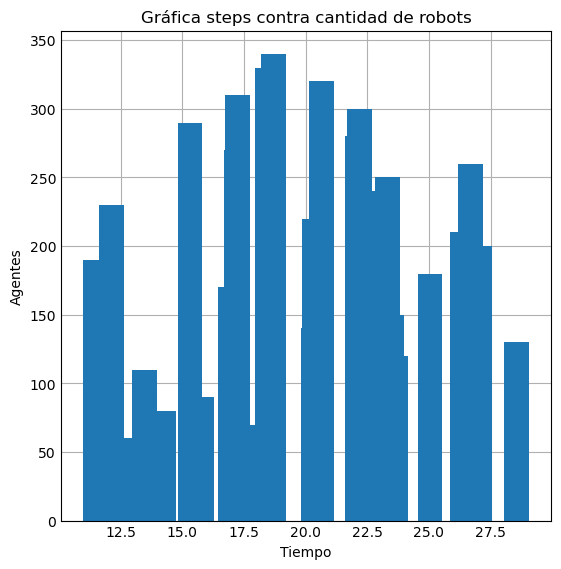

In [109]:
fig = plt.subplots(figsize=(5,5))
plt.title('Gráfica steps contra cantidad de robots')
plt.xlabel('Tiempo')
plt.ylabel('Agentes')

# Gráfica num agentes vs tiempos
plt.bar(timeAgents, numAgents, width=1, align='edge')
print(np.average(timeAgents))
print(np.average(numAgents))

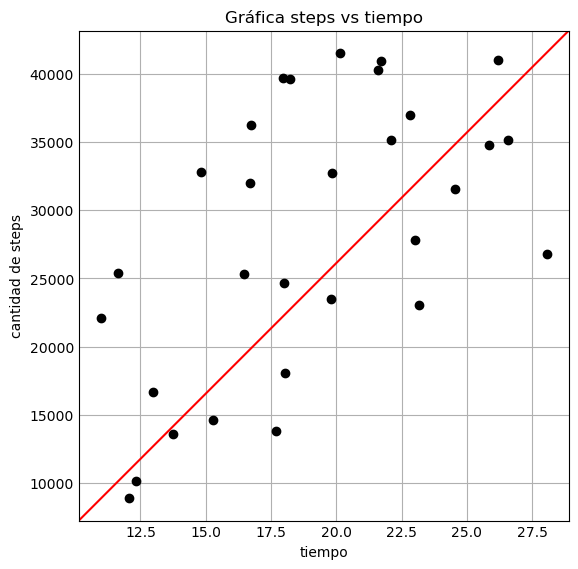

In [111]:
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Gráfica steps vs tiempo')
plt.xlabel('tiempo')
plt.ylabel('cantidad de steps')

# Gráfica num steps vs tiempo


ax.scatter(timeAgents, stepAgents, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

plt.show()




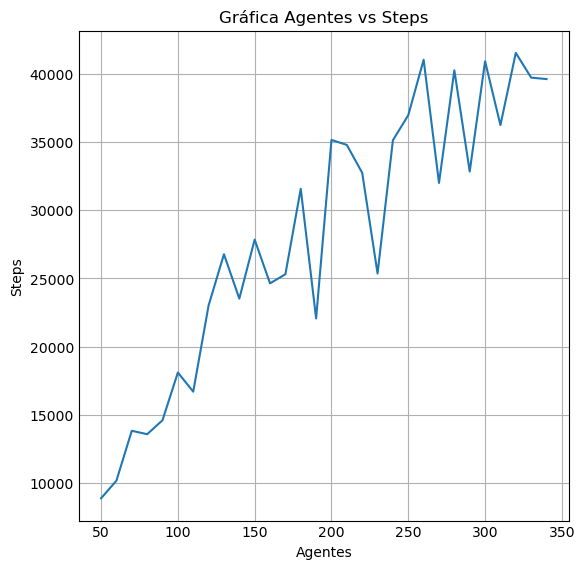

In [101]:
fig = plt.subplots(figsize=(5,5))
plt.title('Gráfica Agentes vs Steps')
plt.xlabel('Agentes')
plt.ylabel('Steps')

# Gráfica num agentes vs steps
plt.plot(numAgents, stepAgents)

# Integración del Modelo
<hr>

El comportamiento del modelo de forma apartada, es decir, simple.

In [27]:
start_time = time.time()
model_2 = RobotVacuumCleanerModel(20, 20, 50, 0.5)

i = 1
final_time = 0
while not model_2.is_all_clean():
    model_2.step()
    i += 1
    final_time += model_2.total_time()


In [28]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model_2.datacollector.get_model_vars_dataframe()


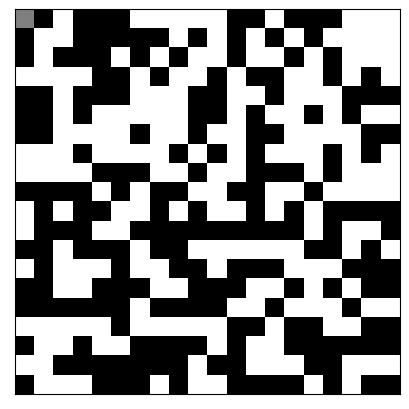

In [29]:
fig, axs = plt.subplots(figsize=(5,5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

In [30]:
anim